# Tutorial

## Tutorial

### Setting up environment

In [91]:
import sys
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import nsforest as ns
from nsforest import utils
from nsforest import preprocessing as pp
from nsforest import nsforesting
from nsforest import evaluating as ev
from nsforest import plotting as pl

### Data Exploration

#### Loading h5ad AnnData file

In [93]:
data_folder = "./data-for-test/"
file = data_folder + "adata_layer1.h5ad"
adata = sc.read_h5ad(file)
adata

AnnData object with n_obs × n_vars = 871 × 16497
    obs: 'cluster'

#### Defining `cluster_header` as cell type annotation. 

**Note:** Some datasets have multiple annotations per sample (ex. "broad_cell_type" and "granular_cell_type"). NS-Forest can be run on multiple `cluster_header`'s. Combining the parent and child markers may improve classification results. 

In [94]:
cluster_header = "cluster"

#### Defining `output_folder` for saving results

In [95]:
output_folder = "./results-from-tutorial/"

#### Looking at sample labels

In [96]:
adata.obs_names

Index(['A01_1_Nuclei_NeuNP_H200_1025_MTG_layer1_BCH9',
       'A01_BCH3_1NeuNP_H200.1030_MTG_Layer_1',
       'A02_BCH1_1NeuNP_H200.1025_MTG_layer_1',
       'A03_1_Nuclei_NeuNP_H200_1025_MTG_layer1_BCH9',
       'A04_1_Nuclei_NeuNP_H200_1025_MTG_layer1_BCH9',
       'A04_BCH1_1NeuNP_H200.1025_MTG_layer_1',
       'A04_BCH3_1NeuNP_H200.1030_MTG_Layer_1',
       'A05_1_Nuclei_NeuNP_H200_1025_MTG_layer1_BCH9',
       'A05_BCH1_1NeuNP_H200.1025_MTG_layer_1',
       'A05_BCH3_1NeuNP_H200.1030_MTG_Layer_1',
       ...
       'P09_1_Nuclei_NeuNN_H200_1025_MTG_layer1_BCH7',
       'P09_1_Nuclei_NeuNN_H200_1025_MTG_layer1_BCH9',
       'P09_1_Nuclei_NeuNN_H200_1030_MTG_layer1_BCH8',
       'P09_BCH1_1NeuNN_H200.1025_MTG_layer_1',
       'P10_1_Nuclei_NeuNN_H200_1025_MTG_layer1_BCH6',
       'P10_1_Nuclei_NeuNN_H200_1025_MTG_layer1_BCH9',
       'P10_BCH1_1NeuNN_H200.1025_MTG_layer_1',
       'P11_1_Nuclei_NeuNN_H200_1025_MTG_layer1_BCH7',
       'P11_1_Nuclei_NeuNN_H200_1025_MTG_layer1_BCH9',


#### Looking at genes

**Note:** `adata.var_names` must be unique. If there is a problem, usually it can be solved by assigning `adata.var.index = adata.var["ensembl_id"]`. 

In [97]:
adata.var_names

Index(['A1CF', 'A2M', 'A2M_AS1', 'A2ML1', 'A2ML1_AS1', 'A2MP1', 'A3GALT2',
       'A4GALT', 'AAAS', 'AACS',
       ...
       'ZUFSP', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=16497)

#### Checking cell annotation sizes 

**Note:** Some datasets are too large and need to be downsampled to be run through the pipeline. When downsampling, be sure to have all the granular cluster annotations represented. 

In [98]:
adata.obs[cluster_header].value_counts()

cluster
e1_e299_SLC17A7_L5b_Cdh13     299
i1_i90_COL5A2_Ndnf_Car4        90
i2_i77_LHX6_Sst_Cbln4          77
i3_i56_BAGE2_Ndnf_Cxcl14       56
i4_i54_MC4R_Ndnf_Cxcl14        54
g1_g48_GLI3_Astro_Gja1         48
i5_i47_TRPC3_Ndnf_Car4         47
i6_i44_GPR149_Vip_Mybpc1       44
i7_i31_CLMP_Ndnf_Cxcl14        31
g2_g27_APBB1IP_Micro_Ctss      27
i8_i27_SNCG_Vip_Mybpc1         27
i9_i22_TAC3_Vip_Mybpc1         22
g3_g18_GPNMB_OPC_Pdgfra        18
i10_i16_TSPAN12_Vip_Mybpc1     16
g4_g9_MOG_Oligo_Opalin          9
i11_i6_EGF_Vip_Mybpc1           6
Name: count, dtype: int64

### Preprocessing

#### Generating scanpy dendrogram

**Note:** Only run if there is no pre-defined dendrogram order. This step can still be run with no effects, but the runtime may increase. 

Dendrogram order is stored in `adata.uns["dendrogram_cluster"]["categories_ordered"]`. 

This dataset has a pre-defined dendrogram order, so running this step is not necessary. 

/Users/raymondleclair/Projects/NLM/NLM-KN/springbok-nlm-kn/.venv/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning:

You’re trying to run this on 16497 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.



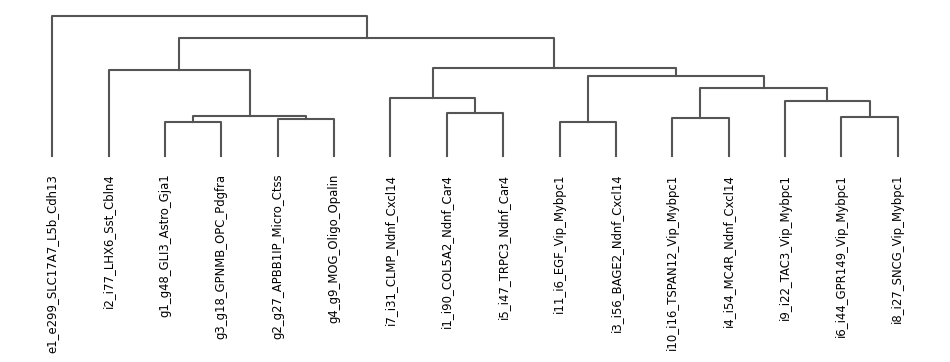

AnnData object with n_obs × n_vars = 871 × 16497
    obs: 'cluster'
    uns: 'pca', 'dendrogram_cluster'
    obsm: 'X_pca'
    varm: 'PCs'

In [99]:
ns.pp.dendrogram(adata, cluster_header, save = True, output_folder = output_folder, outputfilename_suffix = cluster_header)

#### Calculating cluster medians per gene

Run `ns.pp.prep_medians` before running NS-Forest.

**Note:** Do **not** run if evaluating marker lists. Do **not** run when generating scanpy plots (e.g. dot plot, violin plot, matrix plot). 

In [100]:
adata = ns.pp.prep_medians(adata, cluster_header)
adata

Calculating medians...


Calculating medians (means) per cluster: 100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.13it/s]

Saving calculated medians as adata.varm.medians_cluster
--- 0.37642788887023926 seconds ---
median: 0.0
mean: 1.62611
std: 2.4904928
Only positive genes selected. 11688 positive genes out of 16497 total genes


AnnData object with n_obs × n_vars = 871 × 11688
    obs: 'cluster'
    uns: 'pca', 'dendrogram_cluster'
    obsm: 'X_pca'
    varm: 'PCs', 'medians_cluster'

#### Calculating binary scores per gene per cluster

Run `ns.pp.prep_binary_scores` before running NS-Forest. Do not need to run if evaluating marker lists. Do not need to run when generating scanpy plots. 

In [101]:
adata = ns.pp.prep_binary_scores(adata, cluster_header)
adata

Calculating binary scores...


Calculating binary scores per cluster: 100%|████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.34it/s]

Saving calculated binary scores as adata.varm.binary_scores_cluster
--- 11.968657970428467 seconds ---
median: 0.1
mean: 0.2016436226562706
std: 0.25240082537926


AnnData object with n_obs × n_vars = 871 × 11688
    obs: 'cluster'
    uns: 'pca', 'dendrogram_cluster'
    obsm: 'X_pca'
    varm: 'PCs', 'medians_cluster', 'binary_scores_cluster'

#### Plotting median and binary score distributions

Saving median distributions as...
./results-from-tutorial/cluster_medians.png


<Figure size 640x480 with 0 Axes>

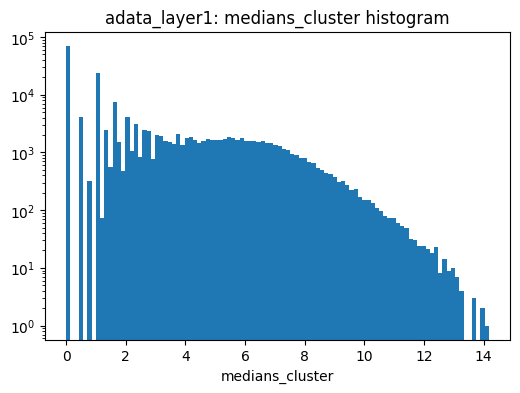

In [102]:
plt.clf()
filename = output_folder + cluster_header + '_medians.png'
print(f"Saving median distributions as...\n{filename}")
a = plt.figure(figsize = (6, 4))
a = plt.hist(adata.varm["medians_" + cluster_header].unstack(), bins = 100)
a = plt.title(f'{file.split("/")[-1].replace(".h5ad", "")}: {"medians_" + cluster_header} histogram')
a = plt.xlabel("medians_" + cluster_header)
a = plt.yscale("log")
a = plt.savefig(filename, bbox_inches='tight')
plt.show()

Saving binary_score distributions as...
./results-from-tutorial/cluster_binary_scores.png


<Figure size 640x480 with 0 Axes>

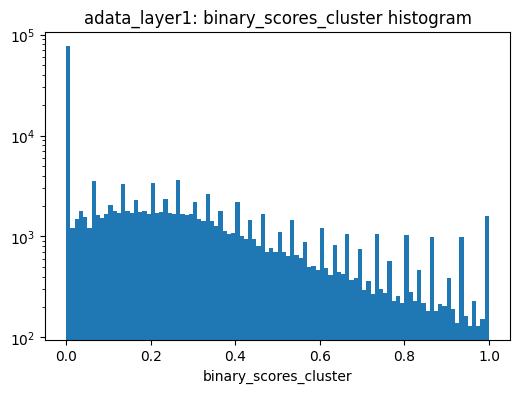

In [103]:
plt.clf()
filename = output_folder + cluster_header + '_binary_scores.png'
print(f"Saving binary_score distributions as...\n{filename}")
a = plt.figure(figsize = (6, 4))
a = plt.hist(adata.varm["binary_scores_" + cluster_header].unstack(), bins = 100)
a = plt.title(f'{file.split("/")[-1].replace(".h5ad", "")}: {"binary_scores_" + cluster_header} histogram')
a = plt.xlabel("binary_scores_" + cluster_header)
a = plt.yscale("log")
a = plt.savefig(filename, bbox_inches='tight')
plt.show()

#### Saving preprocessed AnnData as new h5ad

In [104]:
filename = file.replace(".h5ad", "_preprocessed.h5ad")
print(f"Saving new anndata object as...\n{filename}")
adata.write_h5ad(filename)

Saving new anndata object as...
./data-for-test/adata_layer1_preprocessed.h5ad


### Running NS-Forest

**Note:** Do not run NS-Forest if only evaluating input marker lists. 

In [105]:
outputfilename_prefix = cluster_header
results = nsforesting.NSForest(adata, cluster_header, save_supplementary = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

Preparing adata...
--- 0.005032777786254883 seconds ---
Pre-selecting genes based on binary scores...
	 Threshold (mean + 2 * std): 0.7064452734147906
	Average number of genes after gene_selection in each cluster: 735.5
Saving number of genes selected per cluster as...
./results-from-tutorial/cluster_gene_selection.csv
Number of clusters to evaluate: 16
1 out of 16:
	e1_e299_SLC17A7_L5b_Cdh13
	 Pre-selected 1356 genes to feed into Random Forest.
	['LINC00507']
	fbeta: 0.9597411933860532
	PPV: 0.978021978021978
	recall: 0.8929765886287625
2 out of 16:
	g1_g48_GLI3_Astro_Gja1
	 Pre-selected 583 genes to feed into Random Forest.
	['LINC00498']
	fbeta: 0.95
	PPV: 1.0
	recall: 0.7916666666666666
3 out of 16:
	g2_g27_APBB1IP_Micro_Ctss
	 Pre-selected 420 genes to feed into Random Forest.
	['ADAM28', 'PTPRC']
	fbeta: 0.975609756097561
	PPV: 1.0
	recall: 0.8888888888888888
4 out of 16:
	g3_g18_GPNMB_OPC_Pdgfra
	 Pre-selected 353 genes to feed into Random Forest.
	['GPNMB', 'OLIG2']
	fbeta: 0.8

Calculating medians (means) per cluster: 100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 2395.98it/s]

Saving final results table as...
./results-from-tutorial/cluster_results.csv
--- 12.971474885940552 seconds ---


In [106]:
results

,clusterName,clusterSize,f_score,PPV,recall,TN,FP,FN,TP,marker_count,NSForest_markers,binary_genes,onTarget
0,e1_e299_SLC17A7_L5b_Cdh13,299,0.959741,0.978022,0.892977,566,6,32,267,1,[LINC00507],"[SLC17A7, LINC00508, TBR1, ANKRD33B, NPTX1, LI...",0.479336
1,g1_g48_GLI3_Astro_Gja1,48,0.950000,1.000000,0.791667,823,0,10,38,1,[LINC00498],"[LINC00498, SLC25A18, EMX2OS, FAM189A2, SLC7A1...",0.882322
2,g2_g27_APBB1IP_Micro_Ctss,27,0.975610,1.000000,0.888889,844,0,3,24,2,"[ADAM28, PTPRC]","[ADAM28, PLCG2, INPP5D, PTPRC, CSF2RA, P2RY13,...",0.736514
3,g3_g18_GPNMB_OPC_Pdgfra,18,0.862069,1.000000,0.555556,853,0,8,10,2,"[GPNMB, OLIG2]","[GPNMB, COL20A1, OLIG2, STK32A, KLRC3, KLRC2, ...",0.656991
4,g4_g9_MOG_Oligo_Opalin,9,1.000000,1.000000,1.000000,862,0,0,9,1,[ST18],"[ST18, MOBP, CNDP1, MOG, CD22, FOLH1, TF, CARN...",0.622487
5,i10_i16_TSPAN12_Vip_Mybpc1,16,0.803571,0.900000,0.562500,854,1,7,9,2,"[TSPAN12, CHRNB3]","[TSPAN12, TMC5, LINC01539, CHRNB3, FAM46A, ANG...",0.370267
6,i11_i6_EGF_Vip_Mybpc1,6,0.714286,1.000000,0.333333,865,0,4,2,2,"[EGF, FBRSL1]","[EGF, FZD8, KCNJ2_AS1, FBRSL1, TEKT1, NRG3_AS1...",0.356487
7,i1_i90_COL5A2_Ndnf_Car4,90,0.907821,0.970149,0.722222,779,2,25,65,2,"[COL5A2, BMP6]","[NMBR, COL5A2, C8ORF4, PAPSS2, TRPC3, BMP6, SS...",0.299027
8,i2_i77_LHX6_Sst_Cbln4,77,0.816619,0.838235,0.740260,783,11,20,57,1,[LHX6],"[LHX6, FLT3, TAC1, CALB1, RSPO3, TRBC2, GRIK3,...",0.795864
9,i3_i56_BAGE2_Ndnf_Cxcl14,56,0.781250,0.961538,0.446429,814,1,31,25,2,"[BAGE2, SYT10]","[BAGE2, SCN5A, GREM2, FAM19A4, SYT10, ARHGAP18...",0.282582


#### Plotting classification metrics from NS-Forest results

Saving...
 ./results-from-tutorial/cluster_boxplot_f_score.html


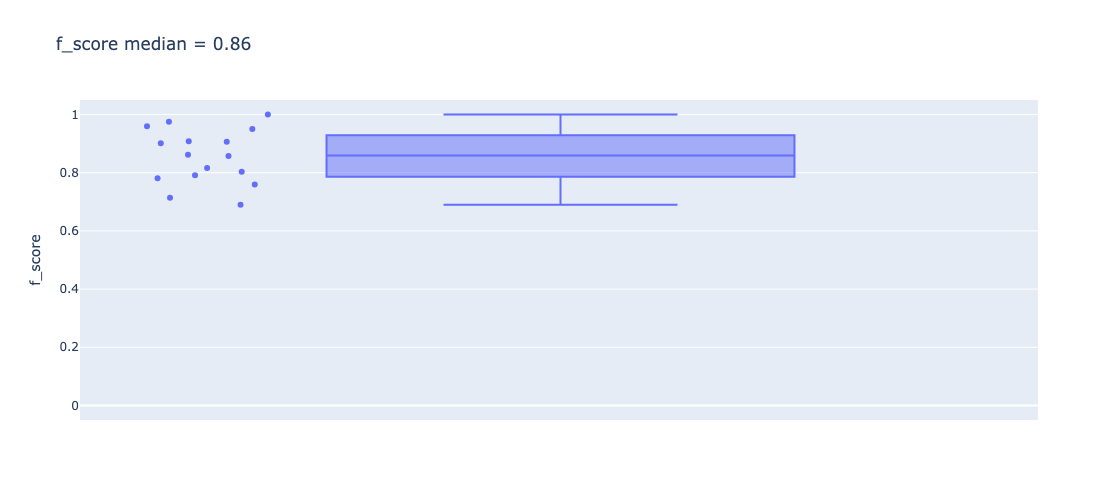

In [107]:
ns.pl.boxplot(results, "f_score", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

Saving...
 ./results-from-tutorial/cluster_boxplot_PPV.html


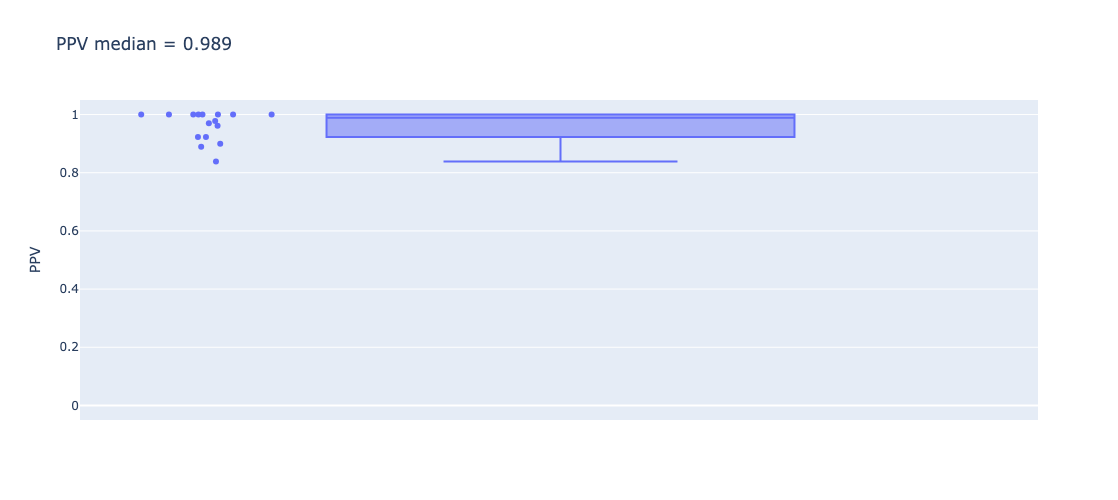

In [108]:
ns.pl.boxplot(results, "PPV", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

Saving...
 ./results-from-tutorial/cluster_boxplot_recall.html


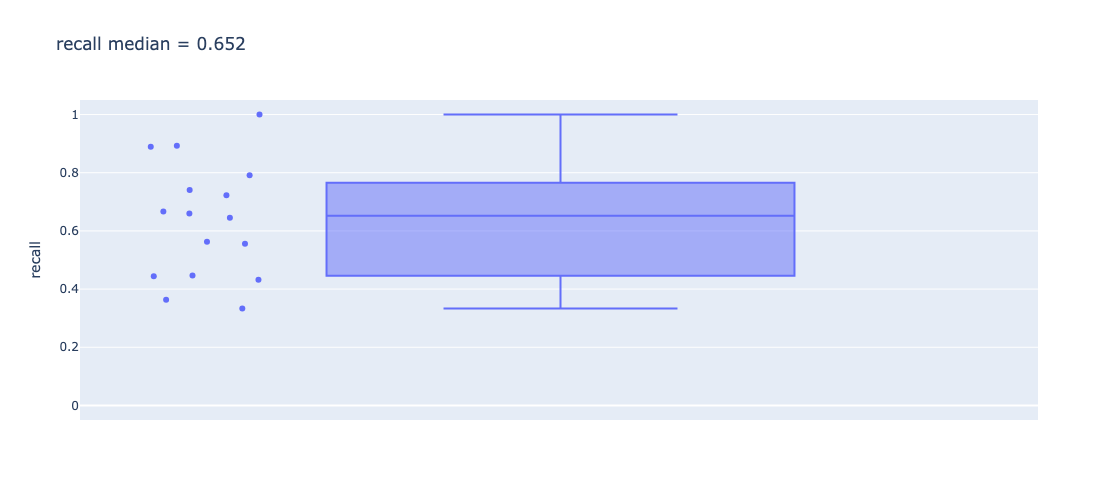

In [109]:
ns.pl.boxplot(results, "recall", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

Saving...
 ./results-from-tutorial/cluster_boxplot_onTarget.html


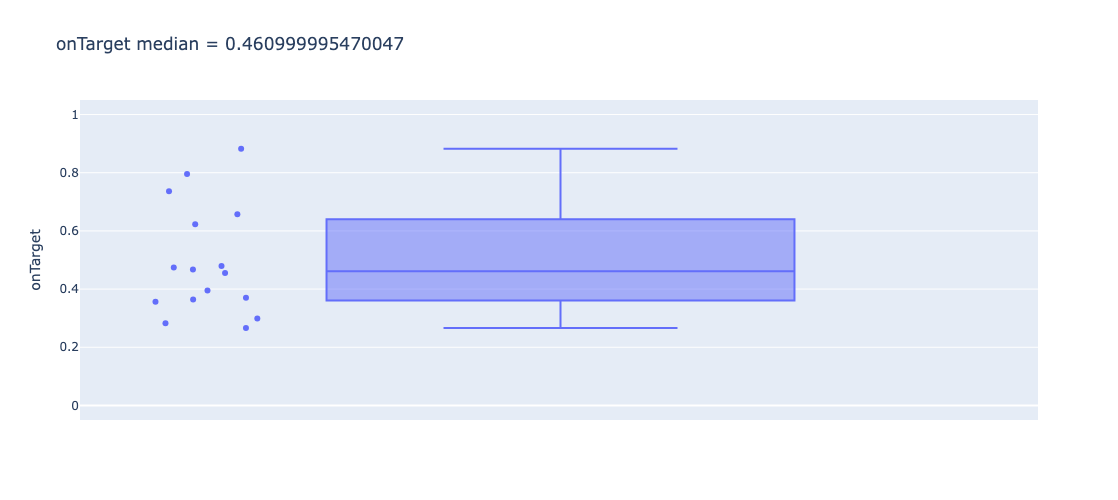

In [110]:
ns.pl.boxplot(results, "onTarget", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

Saving...
 ./results-from-tutorial/cluster_scatter_f_score.html


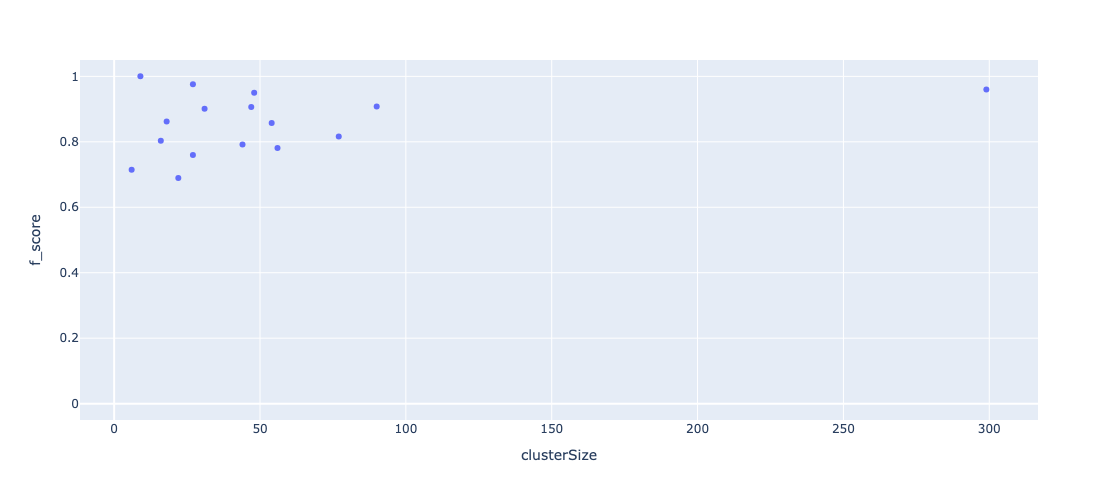

In [111]:
ns.pl.scatter_w_clusterSize(results, "f_score", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

Saving...
 ./results-from-tutorial/cluster_scatter_PPV.html


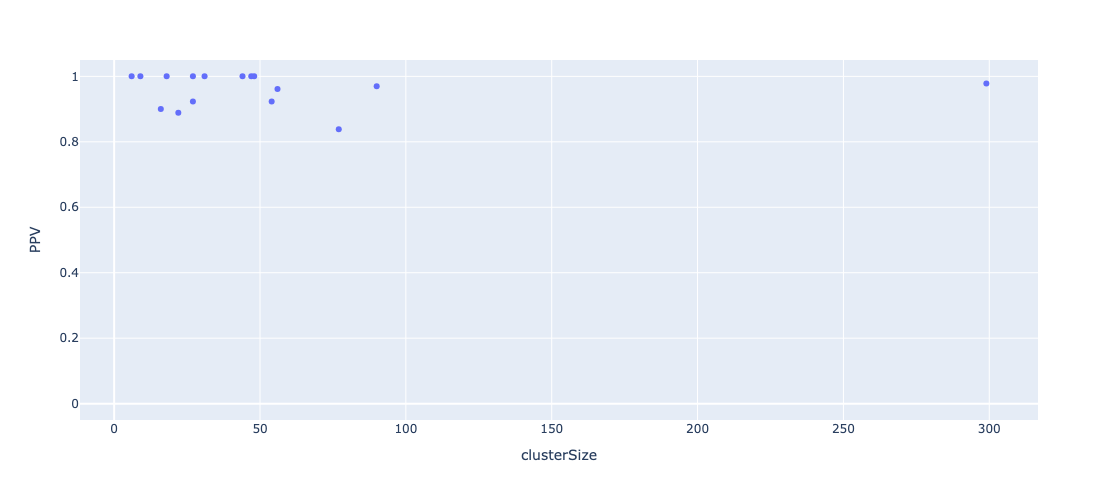

In [112]:
ns.pl.scatter_w_clusterSize(results, "PPV", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

Saving...
 ./results-from-tutorial/cluster_scatter_recall.html


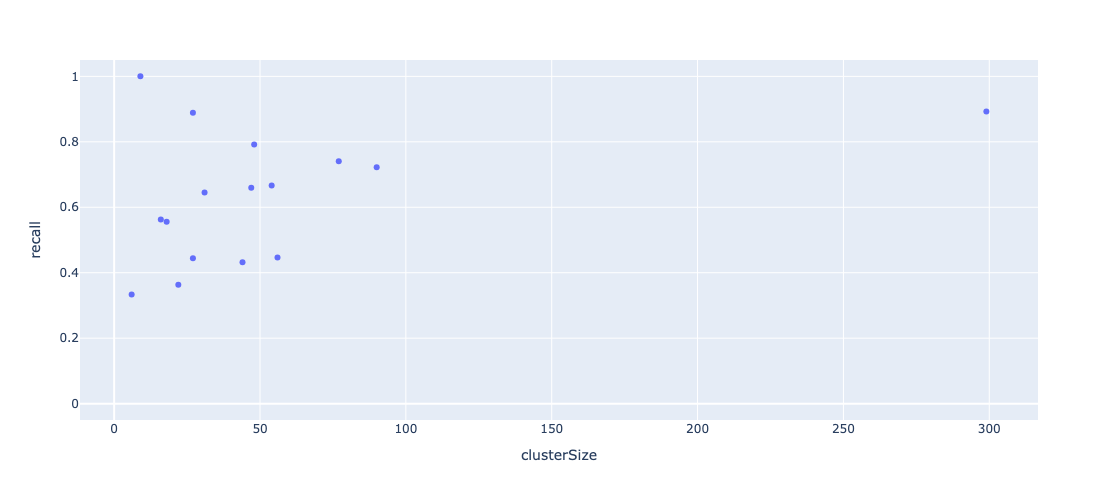

In [113]:
ns.pl.scatter_w_clusterSize(results, "recall", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

Saving...
 ./results-from-tutorial/cluster_scatter_onTarget.html


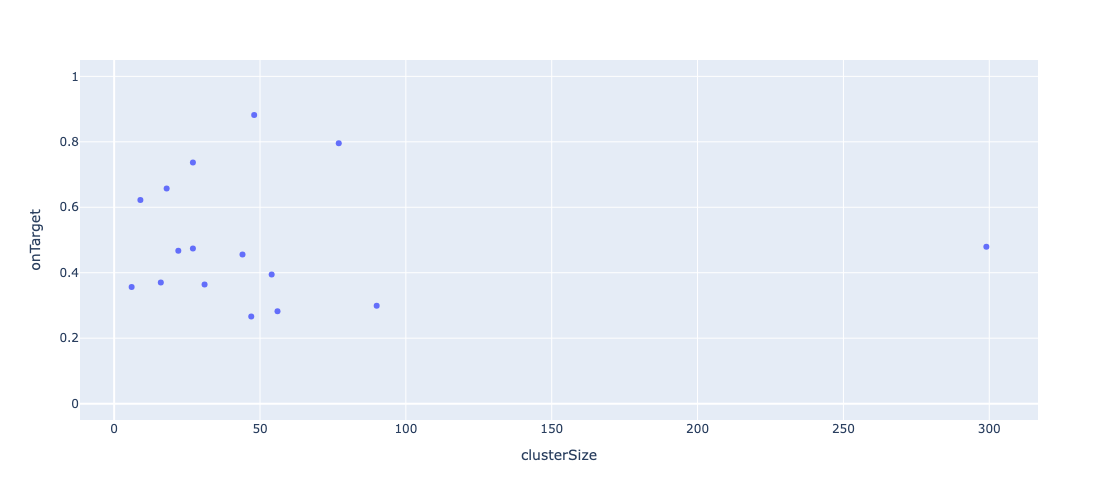

In [114]:
ns.pl.scatter_w_clusterSize(results, "onTarget", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

### Plotting scanpy dot plot, violin plot, matrix plot for NS-Forest markers

**Note:** Assign pre-defined dendrogram order here **or** use `adata.uns["dendrogram_" + cluster_header]["categories_ordered"]`. 

In [115]:
to_plot = results.copy()

In [116]:
dendrogram = [] # custom dendrogram order
dendrogram = list(adata.uns["dendrogram_" + cluster_header]["categories_ordered"])
to_plot["clusterName"] = to_plot["clusterName"].astype("category")
to_plot["clusterName"] = to_plot["clusterName"].cat.set_categories(dendrogram)
to_plot = to_plot.sort_values("clusterName")
to_plot = to_plot.rename(columns = {"NSForest_markers": "markers"})
to_plot.head()

,clusterName,clusterSize,f_score,PPV,recall,TN,FP,FN,TP,marker_count,markers,binary_genes,onTarget
0,e1_e299_SLC17A7_L5b_Cdh13,299,0.959741,0.978022,0.892977,566,6,32,267,1,[LINC00507],"[SLC17A7, LINC00508, TBR1, ANKRD33B, NPTX1, LI...",0.479336
8,i2_i77_LHX6_Sst_Cbln4,77,0.816619,0.838235,0.740260,783,11,20,57,1,[LHX6],"[LHX6, FLT3, TAC1, CALB1, RSPO3, TRBC2, GRIK3,...",0.795864
1,g1_g48_GLI3_Astro_Gja1,48,0.950000,1.000000,0.791667,823,0,10,38,1,[LINC00498],"[LINC00498, SLC25A18, EMX2OS, FAM189A2, SLC7A1...",0.882322
3,g3_g18_GPNMB_OPC_Pdgfra,18,0.862069,1.000000,0.555556,853,0,8,10,2,"[GPNMB, OLIG2]","[GPNMB, COL20A1, OLIG2, STK32A, KLRC3, KLRC2, ...",0.656991
2,g2_g27_APBB1IP_Micro_Ctss,27,0.975610,1.000000,0.888889,844,0,3,24,2,"[ADAM28, PTPRC]","[ADAM28, PLCG2, INPP5D, PTPRC, CSF2RA, P2RY13,...",0.736514


In [117]:
markers_dict = dict(zip(to_plot["clusterName"], to_plot["markers"]))
markers_dict

{'e1_e299_SLC17A7_L5b_Cdh13': ['LINC00507'],
 'i2_i77_LHX6_Sst_Cbln4': ['LHX6'],
 'g1_g48_GLI3_Astro_Gja1': ['LINC00498'],
 'g3_g18_GPNMB_OPC_Pdgfra': ['GPNMB', 'OLIG2'],
 'g2_g27_APBB1IP_Micro_Ctss': ['ADAM28', 'PTPRC'],
 'g4_g9_MOG_Oligo_Opalin': ['ST18'],
 'i7_i31_CLMP_Ndnf_Cxcl14': ['PAX6', 'TGFBR2'],
 'i1_i90_COL5A2_Ndnf_Car4': ['COL5A2', 'BMP6'],
 'i5_i47_TRPC3_Ndnf_Car4': ['NTNG1', 'EYA4'],
 'i11_i6_EGF_Vip_Mybpc1': ['EGF', 'FBRSL1'],
 'i3_i56_BAGE2_Ndnf_Cxcl14': ['BAGE2', 'SYT10'],
 'i10_i16_TSPAN12_Vip_Mybpc1': ['TSPAN12', 'CHRNB3'],
 'i4_i54_MC4R_Ndnf_Cxcl14': ['ARHGAP36', 'ADAM33'],
 'i9_i22_TAC3_Vip_Mybpc1': ['BSPRY', 'MCTP2'],
 'i6_i44_GPR149_Vip_Mybpc1': ['FLT1', 'GPR149'],
 'i8_i27_SNCG_Vip_Mybpc1': ['SNCG', 'EDNRA']}

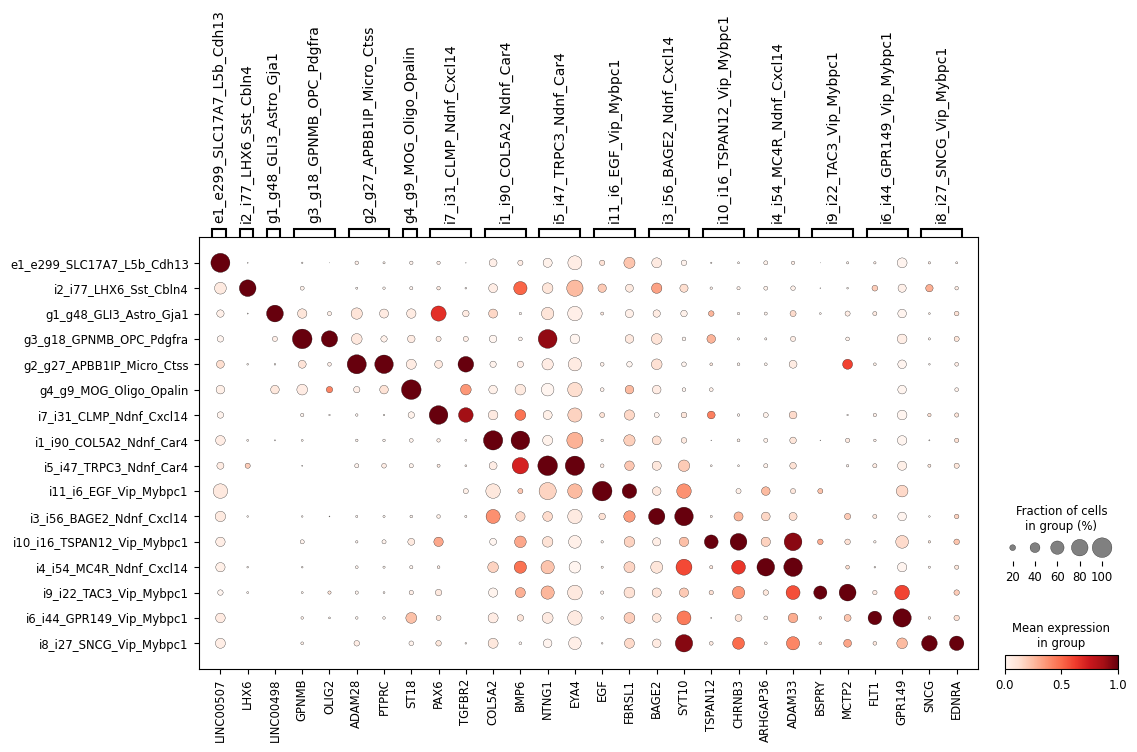

In [118]:
ns.pl.dotplot(adata, markers_dict, cluster_header, dendrogram = dendrogram, save = True, output_folder = output_folder, outputfilename_suffix = outputfilename_prefix)

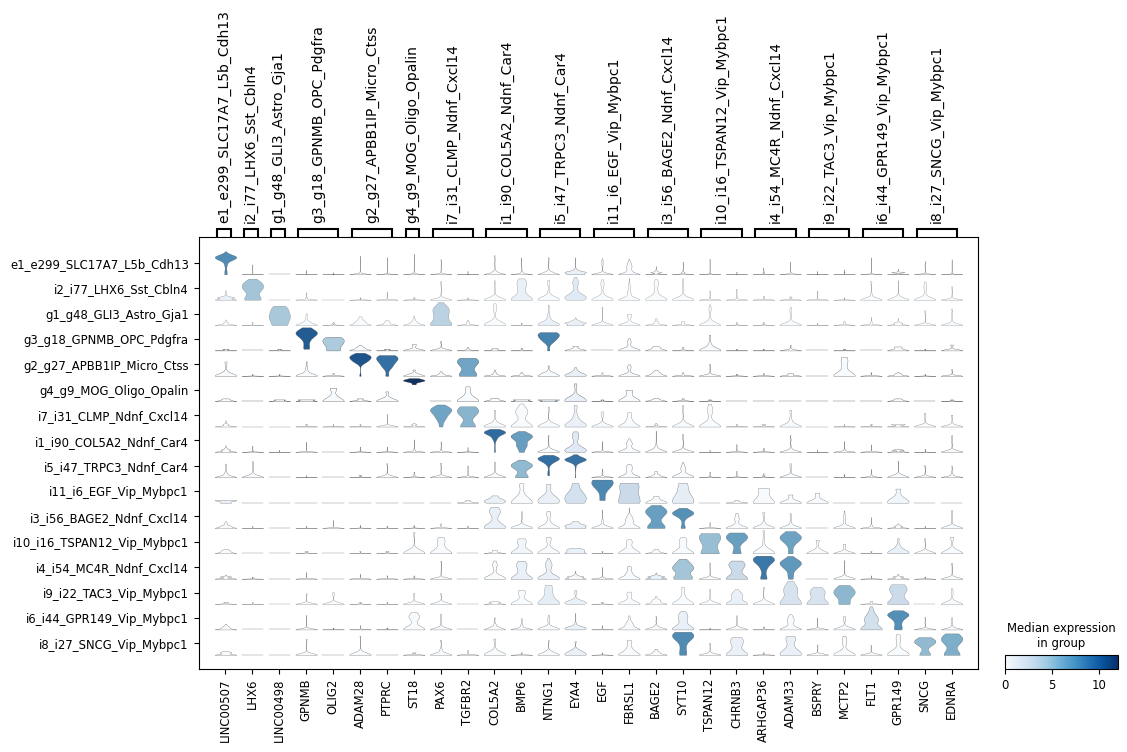

In [119]:
ns.pl.stackedviolin(adata, markers_dict, cluster_header, dendrogram = dendrogram, save = True, output_folder = output_folder, outputfilename_suffix = outputfilename_prefix)

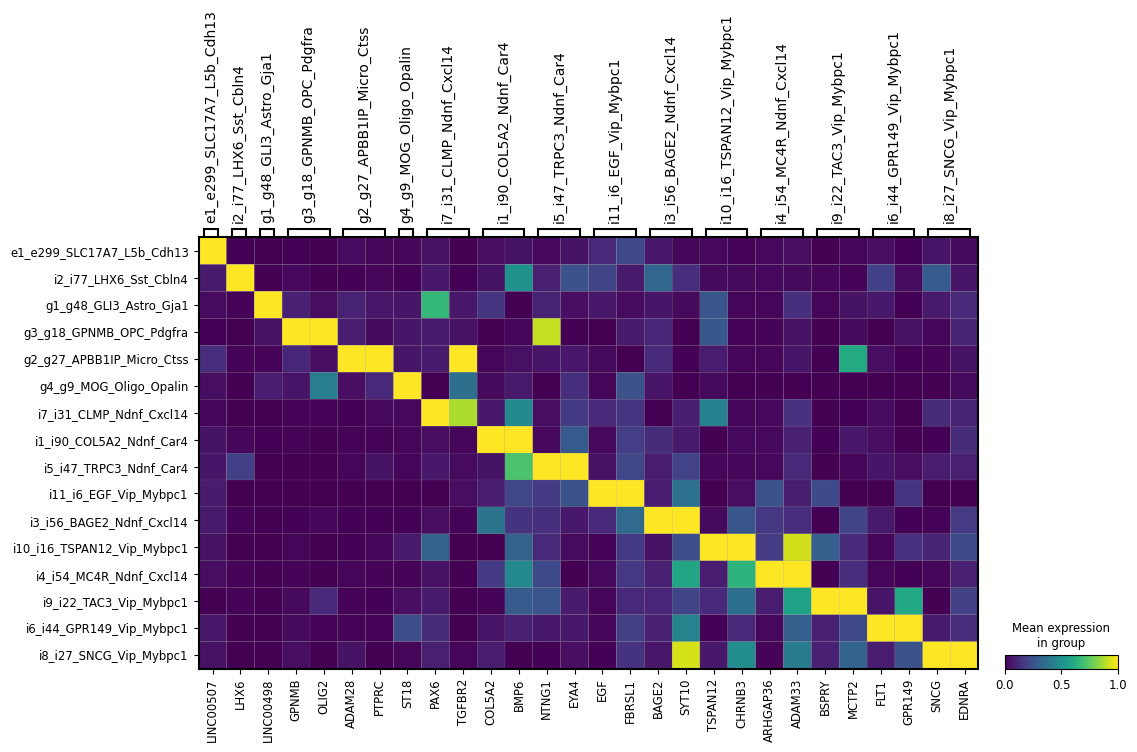

In [120]:
ns.pl.matrixplot(adata, markers_dict, cluster_header, dendrogram = dendrogram, save = True, output_folder = output_folder, outputfilename_suffix = outputfilename_prefix)

### Evaluating input marker list

#### Getting marker list in dictionary format: {cluster: marker_list}

In [121]:
markers = pd.read_csv("./data-for-test/marker_list.csv")
markers_dict = utils.prepare_markers(markers, "clusterName", "markers")
markers_dict

{'e1_e299_SLC17A7_L5b_Cdh13': ['SLC17A7', 'CDH13'],
 'g1_g48_GLI3_Astro_Gja1': ['GLI3', 'GJA1'],
 'g2_g27_APBB1IP_Micro_Ctss': ['APBB1IP', 'CTSS'],
 'g3_g18_GPNMB_OPC_Pdgfra': ['GPNMB', 'PDGFRA'],
 'g4_g9_MOG_Oligo_Opalin': ['MOG', 'OPALIN'],
 'i10_i16_TSPAN12_Vip_Mybpc1': ['TSPAN12', 'VIP', 'MYBPC1'],
 'i11_i6_EGF_Vip_Mybpc1': ['EGF', 'VIP', 'MYBPC1'],
 'i1_i90_COL5A2_Ndnf_Car4': ['COL5A2', 'NDNF', 'CAR4'],
 'i2_i77_LHX6_Sst_Cbln4': ['LHX6', 'SST', 'CBLN4'],
 'i3_i56_BAGE2_Ndnf_Cxcl14': ['BAGE2', 'NDNF', 'CXCL14'],
 'i4_i54_MC4R_Ndnf_Cxcl14': ['MC4R', 'NDNF', 'CXCL14'],
 'i5_i47_TRPC3_Ndnf_Car4': ['TRPC3', 'NDNF', 'CAR4'],
 'i6_i44_GPR149_Vip_Mybpc1': ['GPR149', 'VIP', 'MYBPC1'],
 'i7_i31_CLMP_Ndnf_Cxcl14': ['CLMP', 'NDNF', 'CXCL14'],
 'i8_i27_SNCG_Vip_Mybpc1': ['SNCG', 'VIP', 'MYBPC1'],
 'i9_i22_TAC3_Vip_Mybpc1': ['TAC3', 'VIP', 'MYBPC1']}

In [122]:
outputfilename_prefix = "marker_eval"
evaluation_results = ev.DecisionTree(adata, cluster_header, markers_dict, combinations = False, use_mean = False, 
                                     save_supplementary = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

Preparing data...
--- 0.004807949066162109 seconds ---
Number of clusters to evaluate: 16
1 out of 16:
	e1_e299_SLC17A7_L5b_Cdh13
	marker genes to be evaluated: ['SLC17A7', 'CDH13']
	['SLC17A7', 'CDH13']
	fbeta: 0.9450980392156862
	PPV: 0.9877049180327869
	recall: 0.8060200668896321
2 out of 16:
	g1_g48_GLI3_Astro_Gja1
	marker genes to be evaluated: ['GLI3', 'GJA1']
	['GLI3', 'GJA1']
	fbeta: 0.8928571428571429
	PPV: 1.0
	recall: 0.625
3 out of 16:
	g2_g27_APBB1IP_Micro_Ctss
	marker genes to be evaluated: ['APBB1IP', 'CTSS']
	['APBB1IP', 'CTSS']
	fbeta: 0.38461538461538464
	PPV: 1.0
	recall: 0.1111111111111111
4 out of 16:
	g3_g18_GPNMB_OPC_Pdgfra
	marker genes to be evaluated: ['GPNMB', 'PDGFRA']
	['GPNMB', 'PDGFRA']
	fbeta: 0.9285714285714286
	PPV: 1.0
	recall: 0.7222222222222222
5 out of 16:
	g4_g9_MOG_Oligo_Opalin
	marker genes to be evaluated: ['MOG', 'OPALIN']
	['MOG', 'OPALIN']
	fbeta: 0.9090909090909091
	PPV: 1.0
	recall: 0.6666666666666666
6 out of 16:
	i10_i16_TSPAN12_Vip_Mybp

Calculating medians (means) per cluster: 100%|████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 1655.99it/s]

Saving final results table as...
./results-from-tutorial/marker_eval_results.csv
--- 0.16223716735839844 seconds ---


In [123]:
evaluation_results

,clusterName,clusterSize,f_score,PPV,recall,TN,FP,FN,TP,marker_count,markers,onTarget
0,e1_e299_SLC17A7_L5b_Cdh13,299,0.945098,0.987705,0.806020,569,3,58,241,2,"[SLC17A7, CDH13]",0.548527
1,g1_g48_GLI3_Astro_Gja1,48,0.892857,1.000000,0.625000,823,0,18,30,2,"[GLI3, GJA1]",0.854088
2,g2_g27_APBB1IP_Micro_Ctss,27,0.384615,1.000000,0.111111,844,0,24,3,2,"[APBB1IP, CTSS]",0.955321
3,g3_g18_GPNMB_OPC_Pdgfra,18,0.928571,1.000000,0.722222,853,0,5,13,2,"[GPNMB, PDGFRA]",0.680299
4,g4_g9_MOG_Oligo_Opalin,9,0.909091,1.000000,0.666667,862,0,3,6,2,"[MOG, OPALIN]",1.000000
5,i10_i16_TSPAN12_Vip_Mybpc1,16,0.468750,0.750000,0.187500,854,1,13,3,3,"[TSPAN12, VIP, MYBPC1]",0.209097
6,i11_i6_EGF_Vip_Mybpc1,6,0.000000,0.000000,0.000000,865,0,6,0,3,"[EGF, VIP, MYBPC1]",0.112842
7,i1_i90_COL5A2_Ndnf_Car4,90,0.879888,0.940299,0.700000,777,4,27,63,2,"[COL5A2, NDNF]",0.608344
8,i2_i77_LHX6_Sst_Cbln4,77,0.117647,1.000000,0.025974,794,0,75,2,3,"[LHX6, SST, CBLN4]",0.420224
9,i3_i56_BAGE2_Ndnf_Cxcl14,56,0.564516,0.823529,0.250000,812,3,42,14,3,"[BAGE2, NDNF, CXCL14]",0.103398


#### Plotting classification metrics from marker evaluation

Saving...
 ./results-from-tutorial/marker_eval_boxplot_f_score.html


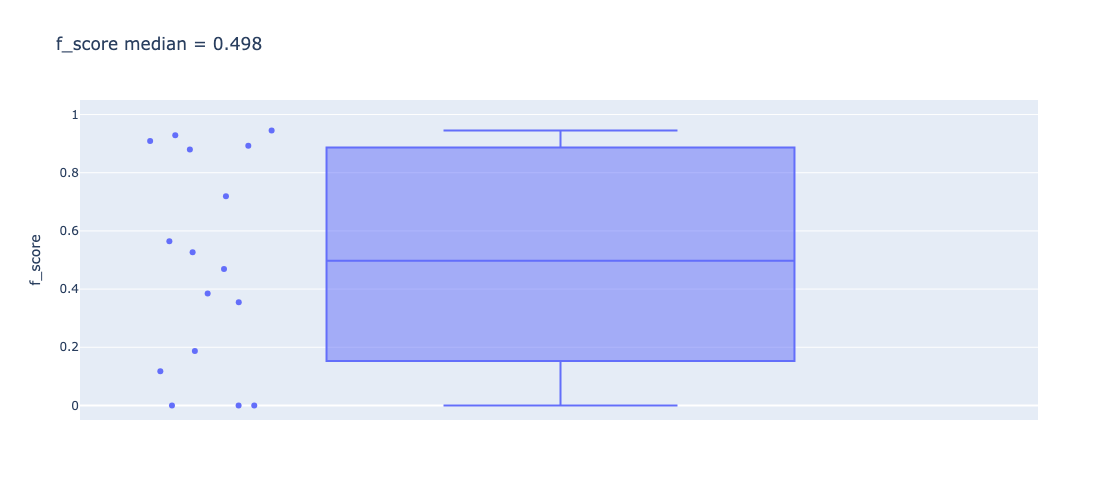

In [124]:
ns.pl.boxplot(evaluation_results, "f_score", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

Saving...
 ./results-from-tutorial/marker_eval_boxplot_PPV.html


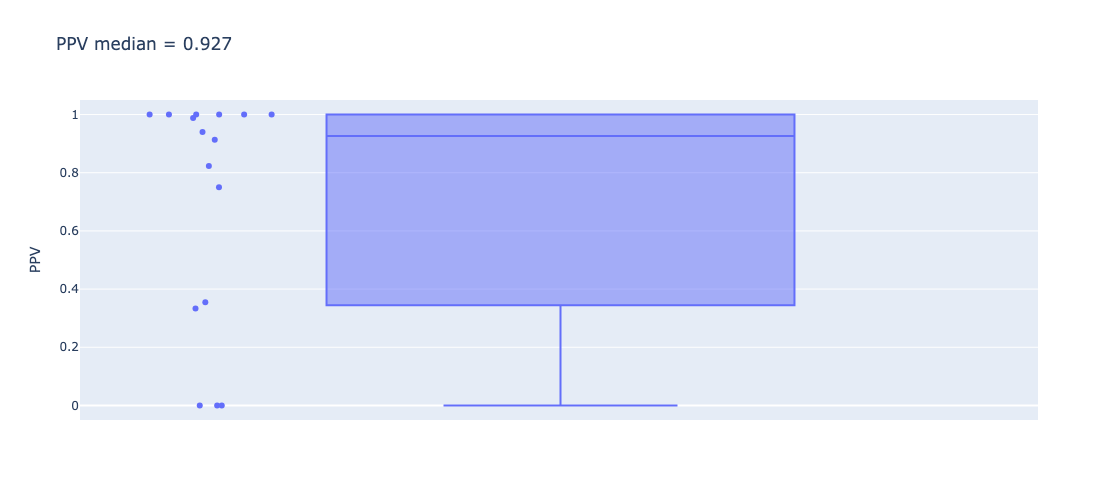

In [125]:
ns.pl.boxplot(evaluation_results, "PPV", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

Saving...
 ./results-from-tutorial/marker_eval_boxplot_recall.html


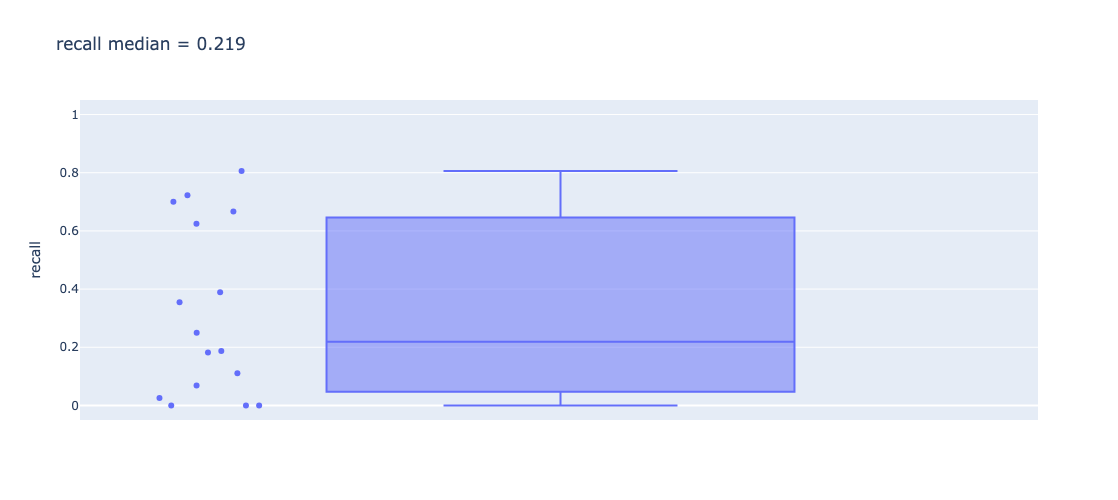

In [126]:
ns.pl.boxplot(evaluation_results, "recall", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

Saving...
 ./results-from-tutorial/marker_eval_boxplot_onTarget.html


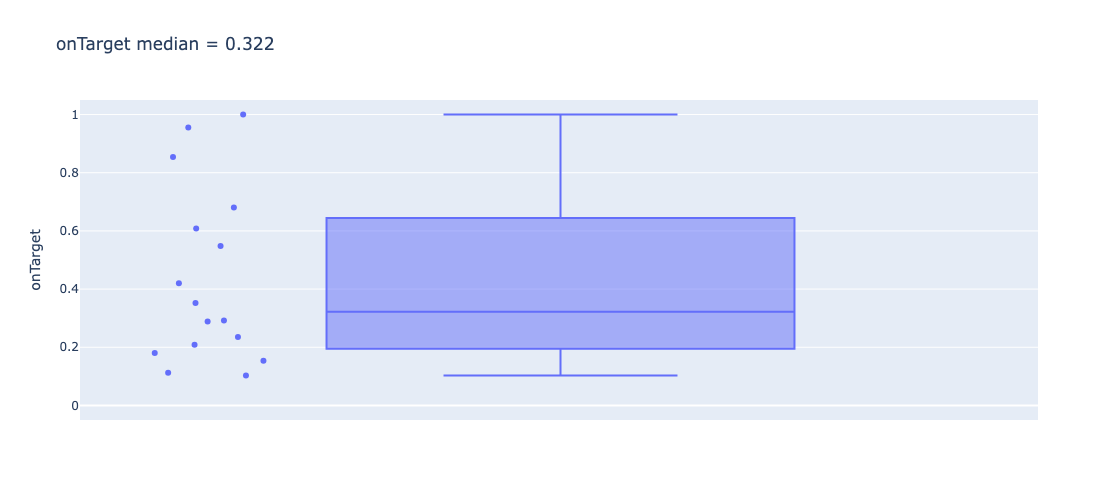

In [127]:
ns.pl.boxplot(evaluation_results, "onTarget", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

Saving...
 ./results-from-tutorial/marker_eval_scatter_f_score.html


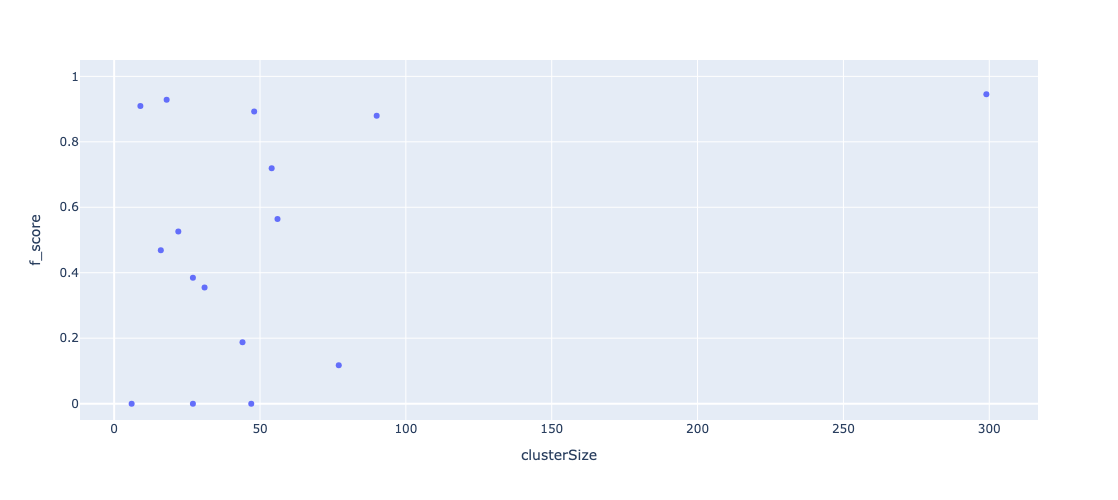

In [128]:
ns.pl.scatter_w_clusterSize(evaluation_results, "f_score", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

Saving...
 ./results-from-tutorial/marker_eval_scatter_PPV.html


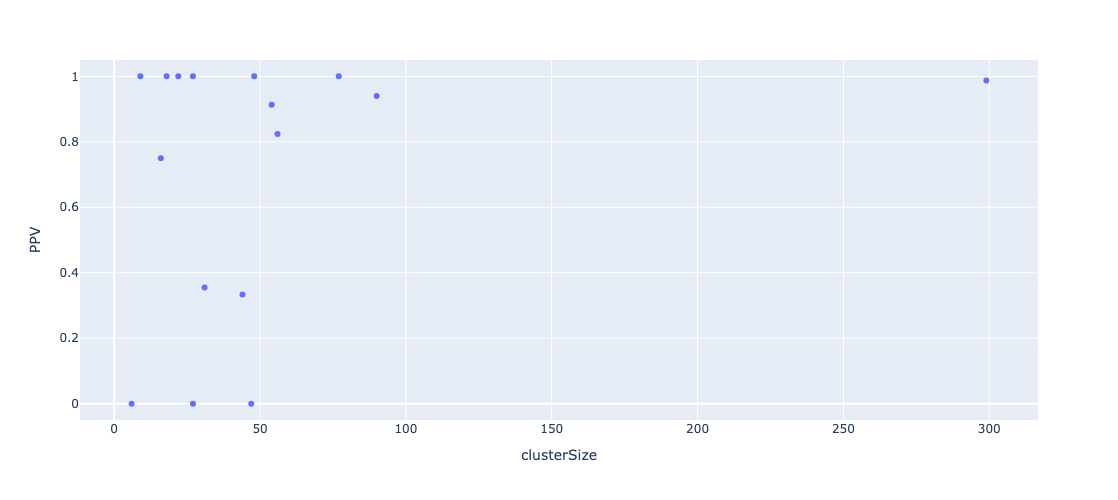

In [129]:
ns.pl.scatter_w_clusterSize(evaluation_results, "PPV", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

Saving...
 ./results-from-tutorial/marker_eval_scatter_recall.html


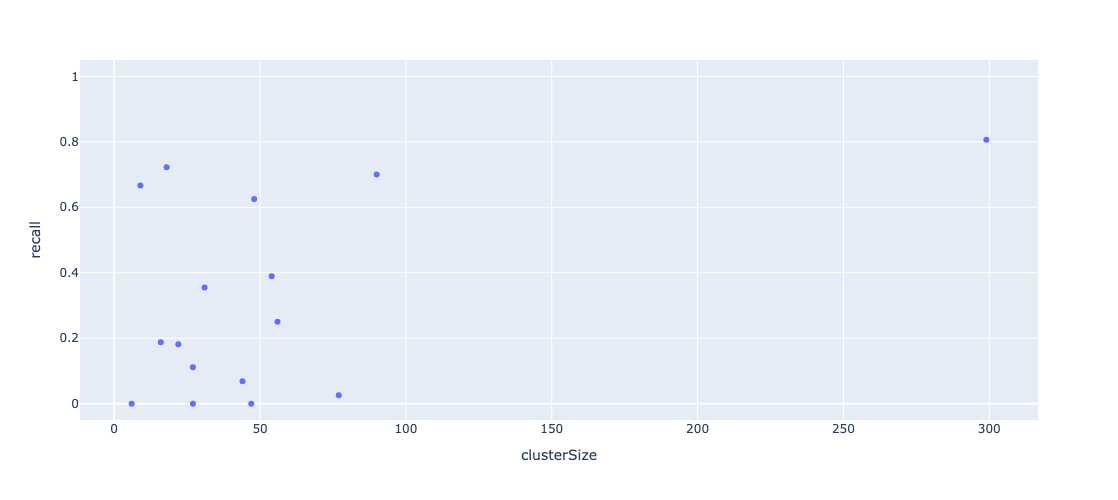

In [130]:
ns.pl.scatter_w_clusterSize(evaluation_results, "recall", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

Saving...
 ./results-from-tutorial/marker_eval_scatter_onTarget.html


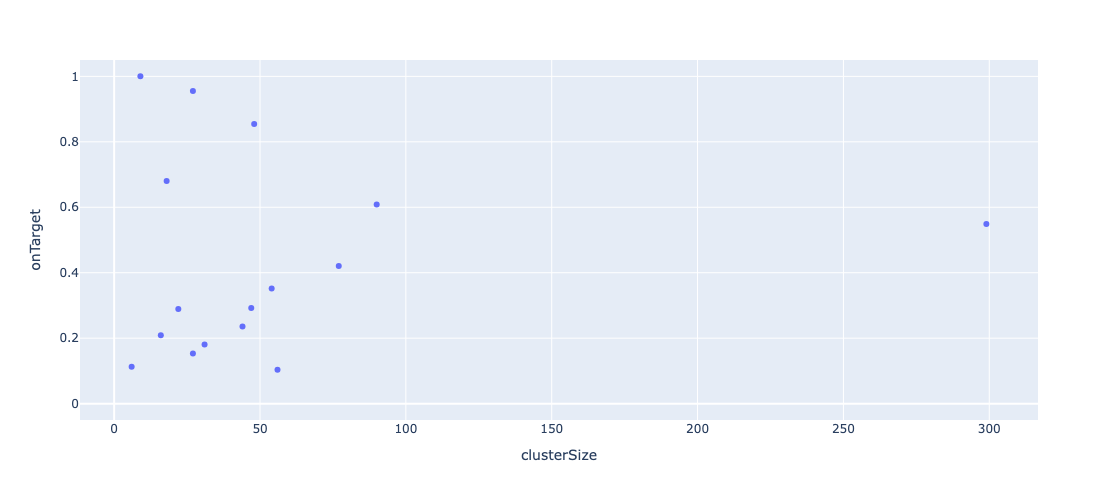

In [131]:
ns.pl.scatter_w_clusterSize(evaluation_results, "onTarget", save = True, output_folder = output_folder, outputfilename_prefix = outputfilename_prefix)

### Plotting scanpy dot plot, violin plot, matrix plot for input marker list

**Note:** Assign pre-defined dendrogram order here **or** use `adata.uns["dendrogram_" + cluster_header]["categories_ordered"]`. 

In [132]:
to_plot = evaluation_results.copy()

In [133]:
dendrogram = [] # custom dendrogram order
dendrogram = list(adata.uns["dendrogram_" + cluster_header]["categories_ordered"])
to_plot["clusterName"] = to_plot["clusterName"].astype("category")
to_plot["clusterName"] = to_plot["clusterName"].cat.set_categories(dendrogram)
to_plot = to_plot.sort_values("clusterName").reset_index(drop = True)
to_plot = to_plot.rename(columns = {"NSForest_markers": "markers"})
to_plot.head()

,clusterName,clusterSize,f_score,PPV,recall,TN,FP,FN,TP,marker_count,markers,onTarget
0,e1_e299_SLC17A7_L5b_Cdh13,299,0.945098,0.987705,0.806020,569,3,58,241,2,"[SLC17A7, CDH13]",0.548527
1,i2_i77_LHX6_Sst_Cbln4,77,0.117647,1.000000,0.025974,794,0,75,2,3,"[LHX6, SST, CBLN4]",0.420224
2,g1_g48_GLI3_Astro_Gja1,48,0.892857,1.000000,0.625000,823,0,18,30,2,"[GLI3, GJA1]",0.854088
3,g3_g18_GPNMB_OPC_Pdgfra,18,0.928571,1.000000,0.722222,853,0,5,13,2,"[GPNMB, PDGFRA]",0.680299
4,g2_g27_APBB1IP_Micro_Ctss,27,0.384615,1.000000,0.111111,844,0,24,3,2,"[APBB1IP, CTSS]",0.955321


In [134]:
markers_dict = dict(zip(to_plot["clusterName"], to_plot["markers"]))
markers_dict

{'e1_e299_SLC17A7_L5b_Cdh13': ['SLC17A7', 'CDH13'],
 'i2_i77_LHX6_Sst_Cbln4': ['LHX6', 'SST', 'CBLN4'],
 'g1_g48_GLI3_Astro_Gja1': ['GLI3', 'GJA1'],
 'g3_g18_GPNMB_OPC_Pdgfra': ['GPNMB', 'PDGFRA'],
 'g2_g27_APBB1IP_Micro_Ctss': ['APBB1IP', 'CTSS'],
 'g4_g9_MOG_Oligo_Opalin': ['MOG', 'OPALIN'],
 'i7_i31_CLMP_Ndnf_Cxcl14': ['CLMP', 'NDNF', 'CXCL14'],
 'i1_i90_COL5A2_Ndnf_Car4': ['COL5A2', 'NDNF'],
 'i5_i47_TRPC3_Ndnf_Car4': ['TRPC3', 'NDNF'],
 'i11_i6_EGF_Vip_Mybpc1': ['EGF', 'VIP', 'MYBPC1'],
 'i3_i56_BAGE2_Ndnf_Cxcl14': ['BAGE2', 'NDNF', 'CXCL14'],
 'i10_i16_TSPAN12_Vip_Mybpc1': ['TSPAN12', 'VIP', 'MYBPC1'],
 'i4_i54_MC4R_Ndnf_Cxcl14': ['MC4R', 'NDNF', 'CXCL14'],
 'i9_i22_TAC3_Vip_Mybpc1': ['TAC3', 'VIP', 'MYBPC1'],
 'i6_i44_GPR149_Vip_Mybpc1': ['GPR149', 'VIP', 'MYBPC1'],
 'i8_i27_SNCG_Vip_Mybpc1': ['SNCG', 'VIP', 'MYBPC1']}

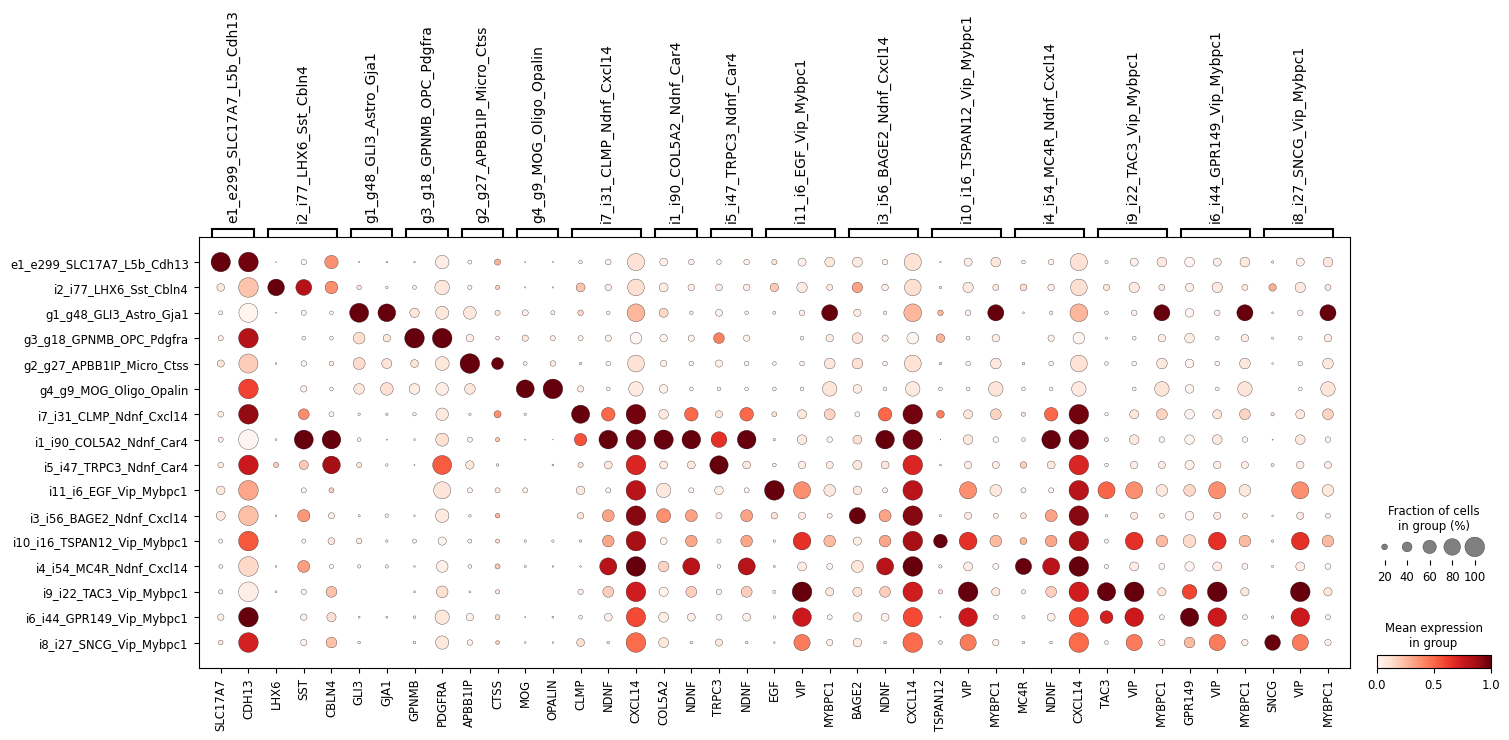

In [135]:
ns.pl.dotplot(adata, markers_dict, cluster_header, dendrogram = dendrogram, save = True, output_folder = output_folder, outputfilename_suffix = outputfilename_prefix)

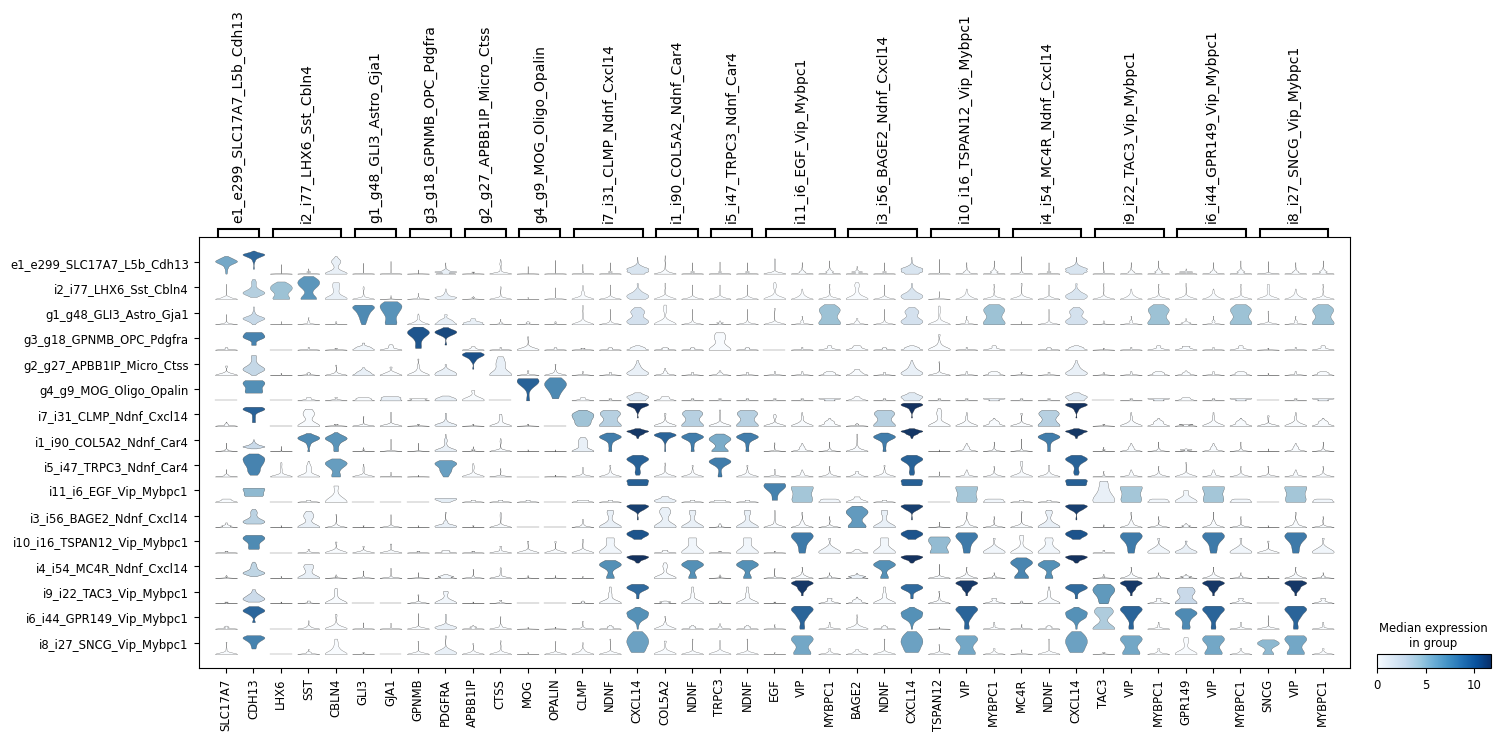

In [136]:
ns.pl.stackedviolin(adata, markers_dict, cluster_header, dendrogram = dendrogram, save = True, output_folder = output_folder, outputfilename_suffix = outputfilename_prefix)

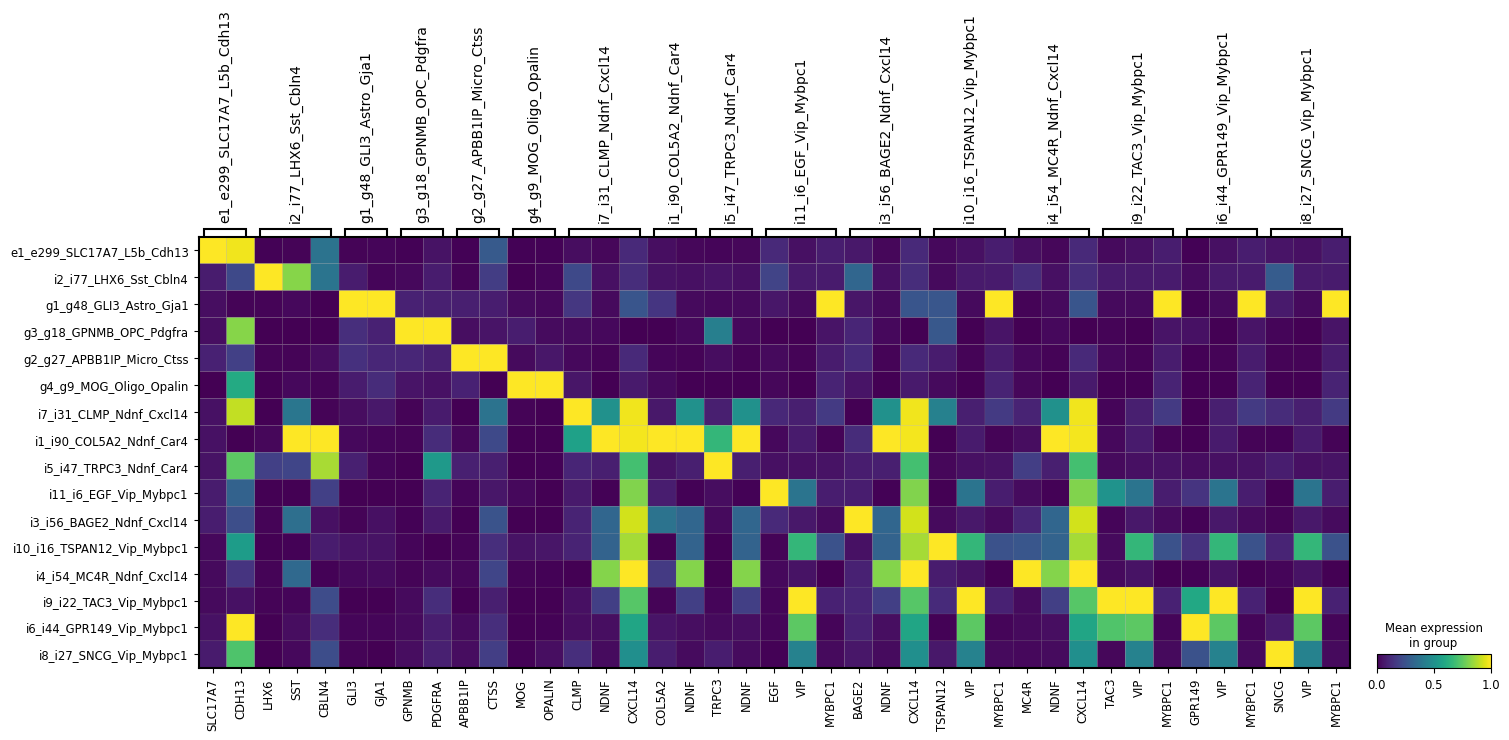

In [137]:
ns.pl.matrixplot(adata, markers_dict, cluster_header, dendrogram = dendrogram, save = True, output_folder = output_folder, outputfilename_suffix = outputfilename_prefix)